In [1]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [2]:
import pandas as pd

# Read the data
df = pd.read_csv("reviews_expanded.csv")
df.shape

(602, 2)

In [3]:
df.head()

,label,review
0,1,This sound track was beautiful! It paints the ...
1,1,I'm reading a lot of reviews saying that this ...
2,1,This soundtrack is my favorite music of all ti...
3,1,I truly like this soundtrack and I enjoy video...
4,1,"If you've played the game, you know how divine..."


In [4]:
# Check for a class imbalance
df.label.value_counts()

label
0    302
1    300
Name: count, dtype: int64

In [5]:
import spacy
nlp = spacy.load("en_core_web_lg")

# Preprocess text, then vectorize it
def preprocess_and_vectorize(text):
    doc = nlp(text)    # create an nlp object out of text

    # Preprocess
    # Take out stop words and punctuation, get the lemma of other words
    filtered_tokens = []    # create a list for the filtered tokens
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        filtered_tokens.append(token.lemma_)    # append the lemma of the word to the list

    # Vectorize
    # Get mean vector of list of words -- embedding of the entire paragraph
    return wv.get_mean_vector(filtered_tokens)

In [6]:
# Preprocess and vectorize the text entries in the news column
# Put the vector embeddings in a new column titled 'vector'
df['vector'] = df['review'].apply(lambda text: preprocess_and_vectorize(text))

In [7]:
df.head()

,label,review,vector
0,1,This sound track was beautiful! It paints the ...,"[0.013495638, 0.008216165, 0.0060283737, 0.023..."
1,1,I'm reading a lot of reviews saying that this ...,"[0.02655866, 0.0047152913, -0.00368195, 0.0409..."
2,1,This soundtrack is my favorite music of all ti...,"[0.024853768, 0.009895753, 0.0031121126, 0.028..."
3,1,I truly like this soundtrack and I enjoy video...,"[0.019452887, 0.0055273096, -0.009283992, 0.02..."
4,1,"If you've played the game, you know how divine...","[0.021789348, -0.002449732, -0.0051915683, 0.0..."


### Train-Test split

In [8]:
from sklearn.model_selection import train_test_split

# Use 20% for testing, 80% for training
X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.label,
    test_size=0.2,
    random_state=2022,
    stratify=df.label
)

### Reshape the X_train and X_test to fit for models

In [9]:
import numpy as np

# Create 2D arrays from the train and test datasets
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

### Train Machine Learning Model

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# 1. Create a GradientBoosting model object
clf = GradientBoostingClassifier()

# 2. Fit with train embeddings
clf.fit(X_train_2d, y_train)

# 3. Get the predictions for the test embeddings
y_pred = clf.predict(X_test_2d)

# 4. Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        61
           1       0.93      0.90      0.92        60

    accuracy                           0.92       121
   macro avg       0.92      0.92      0.92       121
weighted avg       0.92      0.92      0.92       121



### Make Predictions

In [11]:
# The first two are fake, the last is real
test_news = [
    "I have to admit, I was genuinely disappointed with this book. The narrative felt incredibly sluggish, as if the author was dragging the story along without any clear direction. The characters lacked depth and failed to evoke any empathy or interest from me. The plot twists, if you can even call them that, were predictable and did little to redeem the overall lackluster storyline. The writing style, too, was unremarkable, lacking the finesse and creativity I expect from a published work. Frankly, I found myself struggling to finish the book, and by the end, I couldn't shake the feeling that I had wasted both time and money on a forgettable piece of literature. Save yourself the trouble and give this one a pass.",
    "Stumbled upon this album, and it's a total vibe! From the first track to the last, it's a musical rollercoaster that hits all the right notes. The artist's style is crazy diverse, giving you tunes for every mood. The lyrics? Pure feels. The vocals? Straight from the heart. It's quickly become my go-to, the soundtrack to my day. If you're into music that's not just background noise but a real mood booster, this album is the one! Highly recommend.",
    "How can you not love Reese. Great movie just had to buy it so my wife was happy. Great to watch on cold days to snuggle."
]

test_news_vectors = [preprocess_and_vectorize(n) for n in test_news]
clf.predict(test_news_vectors)

array([0, 0, 1])

### Confusion Matrix

Text(95.72222222222221, 0.5, 'Actual Value')

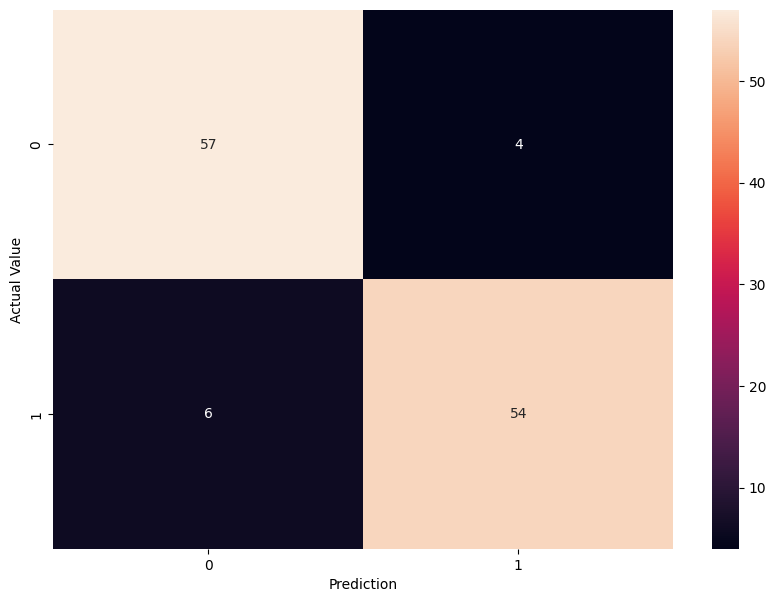

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Actual Value')